In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/My Drive/CS 415 Project'

In [49]:
import pandas as pd
import os
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.cluster import KMeans

#Load images

In [50]:
LABELS_COVID = os.listdir('COVID-19_Radiography_Dataset')
LABELS_MNIST = os.listdir('Medical MNIST')

print(LABELS_COVID)
print()
print(LABELS_MNIST)

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


In [51]:
def load_images_covid(dir, labels, resize_to, image_dir, max_images):
    images = []
    labels_list = []

    max_images_per_label = max_images // len(labels)
    
    set_types = set()

    for label in labels:
        print("Loading", label)
        path = os.path.join(dir, label)

        if image_dir:
            path = os.path.join(path, 'images')

        i = 0
        for img in os.listdir(path)[:max_images_per_label]:
            set_types.add(img.split('.')[-1])
            
            if not img.endswith('.png') and not img.endswith('jpeg'):
                continue
            
            print(i, end = "\r")
            i += 1
            img_path = os.path.join(path, img)
            
            img = cv2.imread(img_path)
                        
            if len(img.shape) > 2:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                
            img = resize(img, resize_to)
            
            # images.append(img.flatten())
            images.append(img)
            
            labels_list.append(labels.index(label))
    
    print("Set Types:", set_types)

    images = np.array(images)
    labels_list = np.array(labels_list)
    return images, labels_list

In [52]:
RESIZE_TO_COVID = (128, 128, 1)
RESIZE_TO_MNIST = (64, 64, 1)
MAX_IMAGES = 1000

covid_images, covid_labels = load_images_covid('COVID-19_Radiography_Dataset', LABELS_COVID, RESIZE_TO_COVID, True, MAX_IMAGES)
mnist_images, mnist_labels = load_images_covid('Medical MNIST', LABELS_MNIST, RESIZE_TO_MNIST, False, MAX_IMAGES)

# covid_dataset = pd.DataFrame()
# covid_dataset['image'] = covid_images
# covid_dataset['label'] = covid_labels

Loading COVID
Loading Lung_Opacity
Loading Normal
Loading Viral Pneumonia
Set Types: {'png'}
Loading AbdomenCT
Loading BreastMRI
Loading ChestCT
Loading CXR
Loading Hand
Loading HeadCT
Set Types: {'jpeg'}


In [53]:
print(covid_images.shape)
print(covid_labels.shape)
print(mnist_images.shape)
print(mnist_labels.shape)

(1000, 128, 128, 1)
(1000,)
(996, 64, 64, 1)
(996,)


# Image Plot

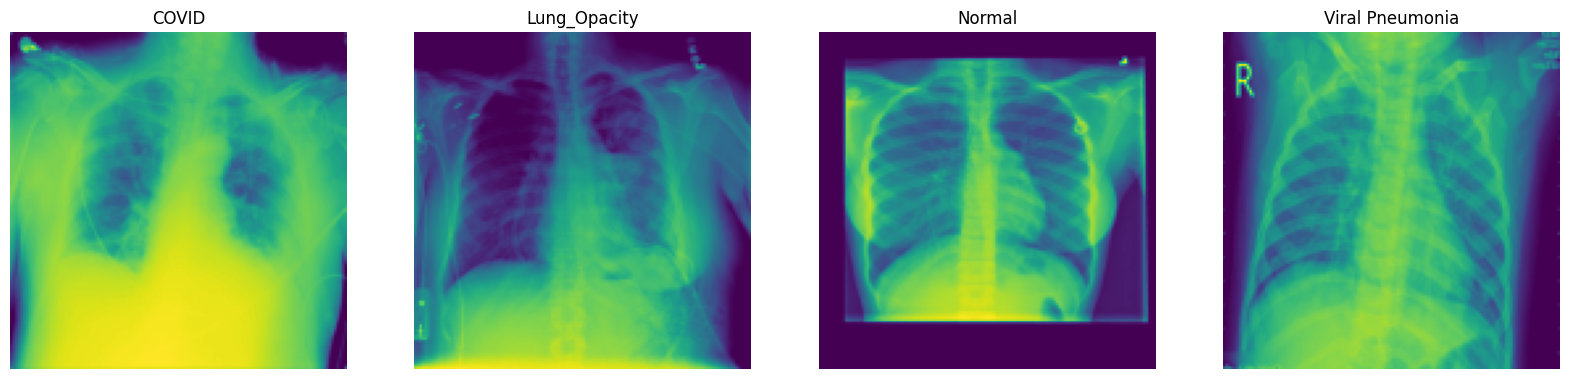

In [54]:
# for all categories in covid dataset output one image
fig, ax = plt.subplots(1, len(LABELS_COVID), figsize = (20, 20))
for i in range(len(LABELS_COVID)):
    ind = np.where(covid_labels == i)[0][0]
    ax[i].imshow(covid_images[ind].reshape(RESIZE_TO_COVID))
    ax[i].set_title(LABELS_COVID[i])
    ax[i].axis('off')
plt.show()

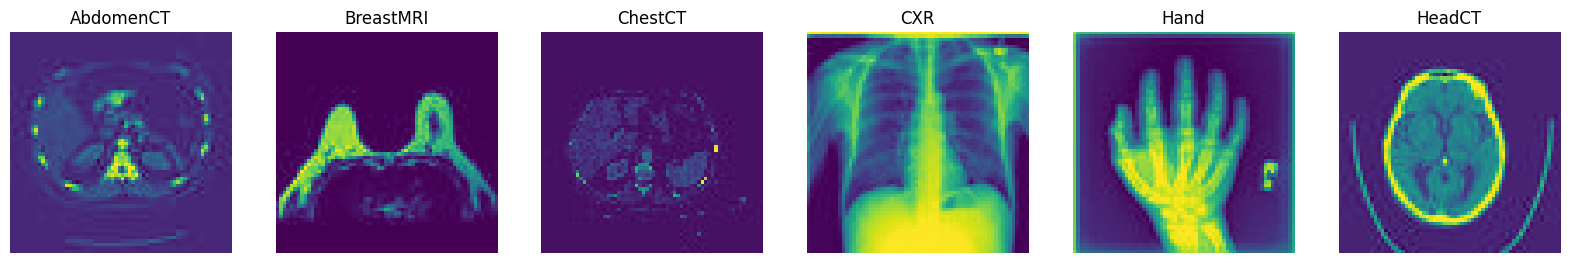

In [55]:
# for all categories in mnist dataset output one image
fig, ax = plt.subplots(1, len(LABELS_MNIST), figsize = (20, 20))
for i in range(len(LABELS_MNIST)):
    ind = np.where(mnist_labels == i)[0][0]
    ax[i].imshow(mnist_images[ind].reshape(RESIZE_TO_MNIST))
    ax[i].set_title(LABELS_MNIST[i])
    ax[i].axis('off')
plt.show()

# HOG EXTRACTION

In [58]:
def extract_hog_features(images):
    hog_features = []

    for image in images:
        features = hog(image,
                       orientations=9,
                       pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2),
                       block_norm='L2-Hys')
        
        hog_features.append(features)

    return np.array(hog_features)

In [61]:
temp_covid = np.array([img.reshape(RESIZE_TO_COVID[0], RESIZE_TO_COVID[1]) for img in covid_images])
temp_mnist = np.array([img.reshape(RESIZE_TO_MNIST[0], RESIZE_TO_MNIST[1]) for img in mnist_images])

X_HOG_COVID = extract_hog_features(temp_covid)
X_HOG_MNIST = extract_hog_features(temp_mnist)

# SVM

#### TRAIN HOG COVID

In [62]:
param_grid={'C':[0.1,1], 
            # 'gamma':[0.0001,0.01,0.1,1], 
            'kernel':['rbf','poly']} 
  
svc=svm.SVC(probability=True) 

model_grid_svm_covid=GridSearchCV(svc,param_grid,verbose=2)

In [63]:
TEST_RATIO = 0.2

X_train_covid_hog, X_test_covid_hog, y_train_covid_hog, y_test_covid_hog = train_test_split(X_HOG_COVID, covid_labels, test_size=TEST_RATIO, random_state=42)

In [17]:
model_grid_svm_covid.fit(X_train_covid_hog, y_train_covid_hog)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=  13.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=  14.9s
[CV] END ..................................C=0.1, kernel=rbf; total time=  16.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=  16.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=  16.1s
[CV] END .................................C=0.1, kernel=poly; total time=  11.5s
[CV] END .................................C=0.1, kernel=poly; total time=  12.9s
[CV] END .................................C=0.1, kernel=poly; total time=  10.6s
[CV] END .................................C=0.1, kernel=poly; total time=   9.7s
[CV] END .................................C=0.1, kernel=poly; total time=   9.9s
[CV] END ....................................C=1, kernel=rbf; total time=  11.8s
[CV] END ....................................C=1,

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf', 'poly']}, verbose=2)

In [18]:
# Get the best parameters and scores
print("Best Parameters:", model_grid_svm_covid.best_params_)
print("Best Cross-Validation Score:", model_grid_svm_covid.best_score_)
print("Best Estimator:", model_grid_svm_covid.best_estimator_)

Best Parameters: {'C': 1, 'kernel': 'poly'}
Best Cross-Validation Score: 0.8275
Best Estimator: SVC(C=1, kernel='poly', probability=True)


#### TEST HOG COVID

In [19]:
y_pred = model_grid_svm_covid.predict(X_test_covid_hog)
accuracy = accuracy_score(y_test_covid_hog, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 79.00%


#### TRAIN HOG MNIST

In [20]:
param_grid={'C':[0.1,1], 
            # 'gamma':[0.0001,0.01,0.1,1], 
            'kernel':['rbf','poly']} 
  
svc=svm.SVC(probability=True) 

model_grid_svm_mnist=GridSearchCV(svc,param_grid,verbose=2)

In [75]:
TEST_RATIO = 0.2

X_train_mnist_hog, X_test_mnist_hog, y_train_mnist_hog, y_test_mnist_hog = train_test_split(X_HOG_MNIST, mnist_labels, test_size=TEST_RATIO, random_state=42)

In [22]:
model_grid_svm_mnist.fit(X_train_mnist_hog, y_train_mnist_hog)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   2.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.3s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   1.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.4s
[CV] END .................................C=0.1, kernel=poly; total time=   0.4s
[CV] END .................................C=0.1, kernel=poly; total time=   0.4s
[CV] END .................................C=0.1, kernel=poly; total time=   0.4s
[CV] END .................................C=0.1, kernel=poly; total time=   0.5s
[CV] END ....................................C=1, kernel=rbf; total time=   0.8s
[CV] END ....................................C=1,

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf', 'poly']}, verbose=2)

In [23]:
# Get the best parameters and scores
print("Best Parameters:", model_grid_svm_mnist.best_params_)
print("Best Cross-Validation Score:", model_grid_svm_mnist.best_score_)
print("Best Estimator:", model_grid_svm_mnist.best_estimator_)

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9987421383647799
Best Estimator: SVC(C=1, probability=True)


#### TEST HOG MNIST

In [24]:
y_pred = model_grid_svm_mnist.predict(X_test_mnist_hog)
accuracy = accuracy_score(y_test_mnist_hog, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.50%


# SIFT + BOW + SVM

In [ ]:
TEST_RATIO = 0.2

X_train_covid_sbs, X_test_covid_sbs, y_train_covid_sbs, y_test_covid_sbs = train_test_split(covid_images, covid_labels, test_size=TEST_RATIO, random_state=42)
X_train_mnist_sbs, X_test_mnist_sbs, y_train_mnist_sbs, y_test_mnist_sbs = train_test_split(mnist_images, mnist_labels, test_size=TEST_RATIO, random_state=42)

In [86]:
print(X_train_covid_sbs.shape)

(800, 128, 128, 1)


In [8]:
sift = cv2.SIFT_create()

def extract_sift_features(image):
    image = (image*255).astype(np.uint8)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors


def extract_sift_features_from_images(images):
    sift_features = []

    for image in images:
        _, features = extract_sift_features(image)
        
        if features is not None:
            sift_features.append(features)

    return np.vstack(sift_features)


def k_means_clustering(features, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans


def image_to_bag_of_features(image, kmeans):
    _, features = extract_sift_features(image)
    
    if features is None:
        return np.zeros(kmeans.n_clusters)
    
    words = kmeans.predict(features)
    histogram, _ = np.histogram(words, bins=kmeans.n_clusters, density=True)
    return histogram

##### K-Means

In [112]:
N_WORDS = 100


image_sift_features = extract_sift_features_from_images(X_train_covid_sbs)
kmeans_covid = k_means_clustering(image_sift_features, N_WORDS)

image_sift_features = extract_sift_features_from_images(X_train_mnist_sbs)
kmeans_mnist = k_means_clustering(image_sift_features, N_WORDS)

In [118]:
print(image_sift_features.shape)

(17009, 128)


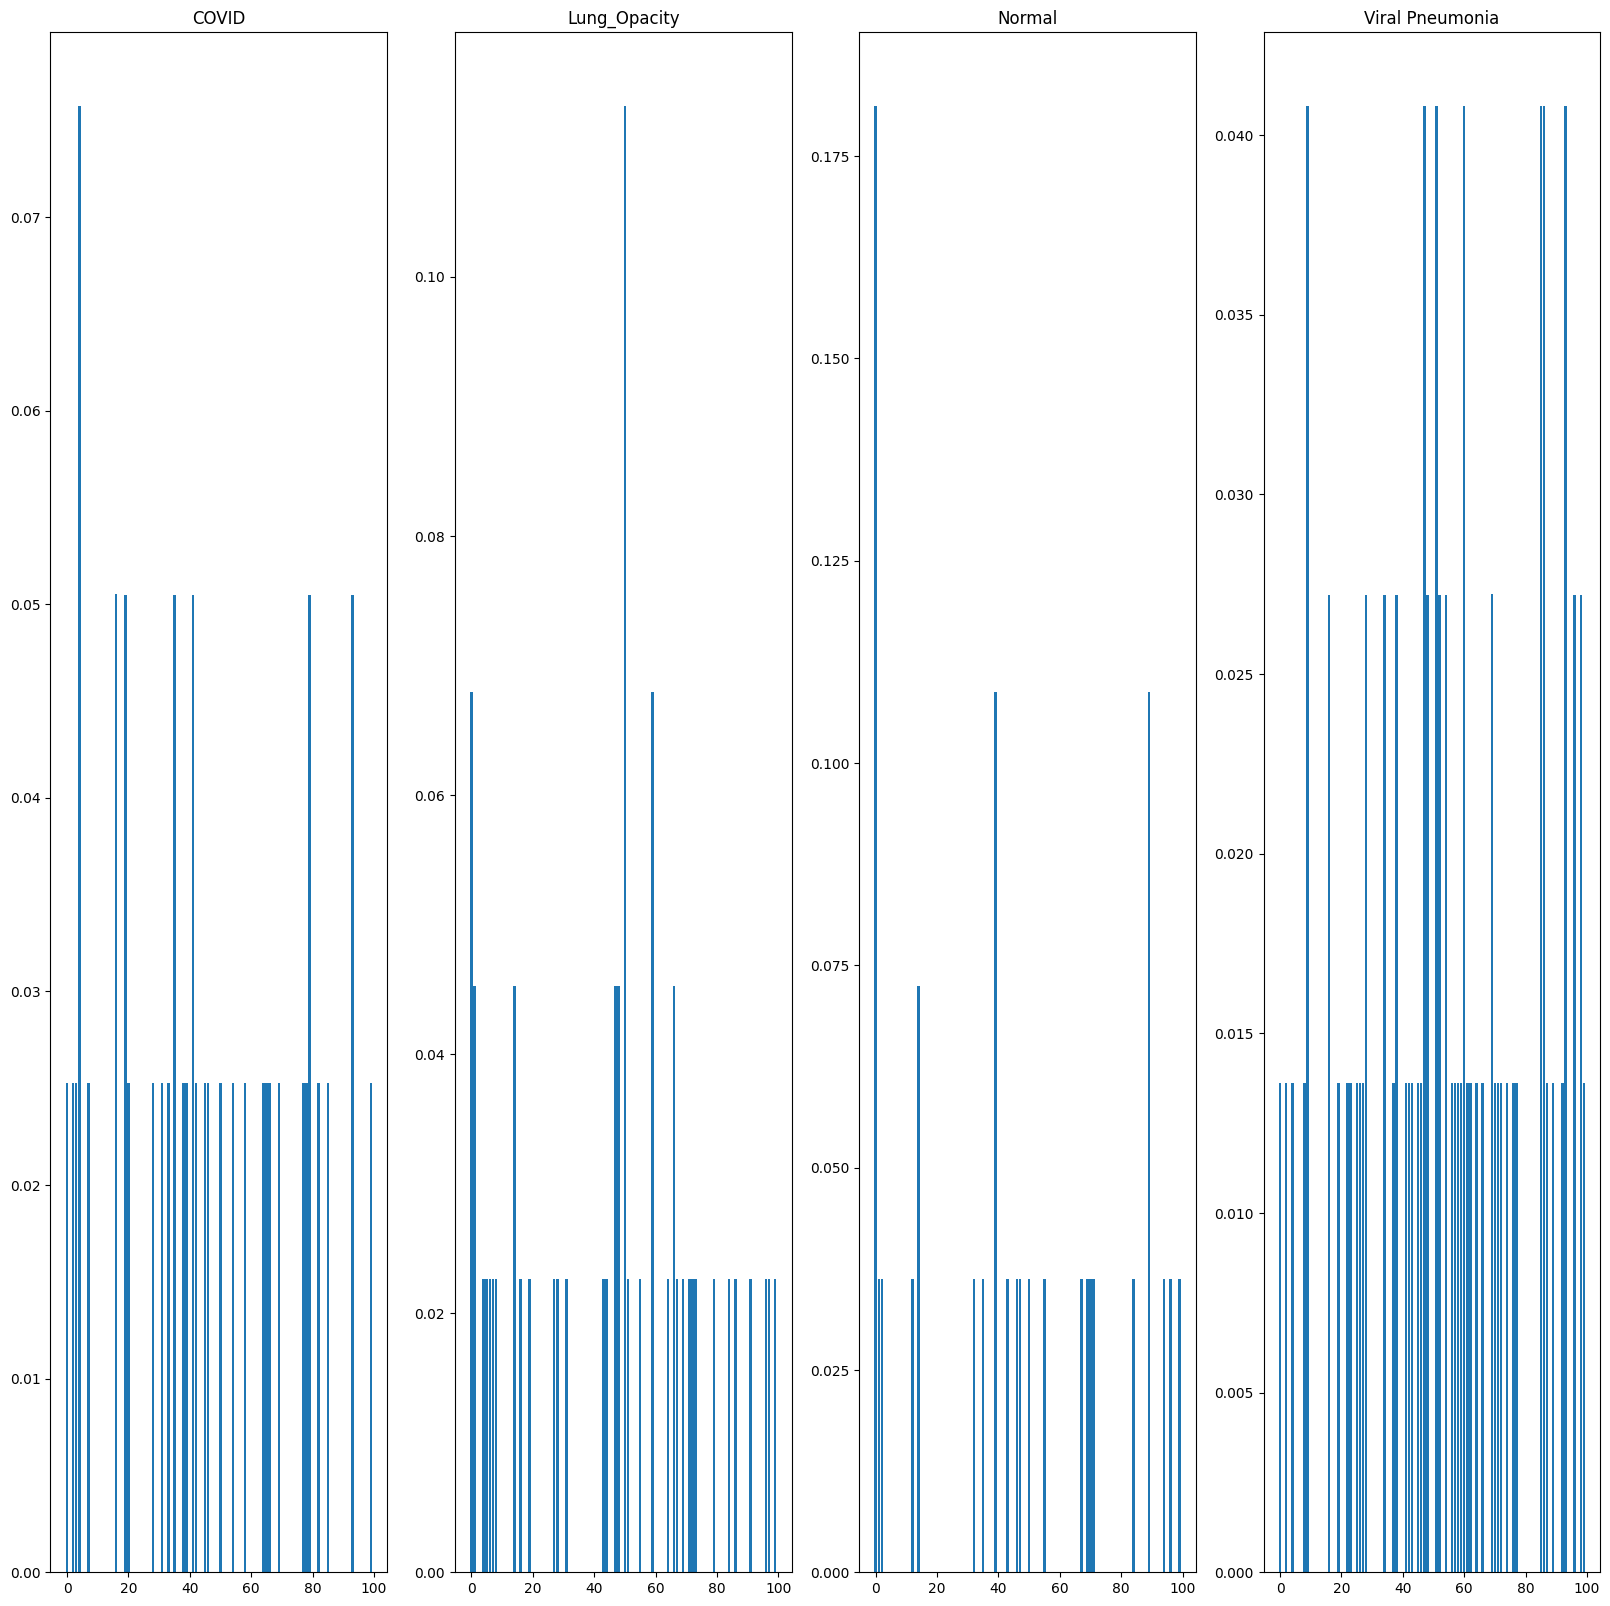

In [119]:
# plot one image for each category with its bag of features histogram

fig, ax = plt.subplots(1, len(LABELS_COVID), figsize = (20, 20))
for i in range(len(LABELS_COVID)):
    ind = np.where(y_train_covid_sbs == i)[0][0]
    histogram = image_to_bag_of_features(X_train_covid_sbs[ind], kmeans_covid)
    ax[i].bar(range(N_WORDS), histogram)
    ax[i].set_title(LABELS_COVID[i])
plt.show()

# fig, ax = plt.subplots(1, len(LABELS_COVID), figsize = (20, 20))
# for i in range(len(LABELS_COVID)):
#     ind = np.where(y_train_covid_sbs == i)[0][0]
    
#     # get the features'
#     image = X_train_covid_sbs[ind]
    
#     # print(image.shape, image.dtype)
#     print(max(image.flatten()), min(image.flatten()))
    
#     temp_img = (image * 255).astype(np.uint8)
        
#     keypoints, _ = extract_sift_features(temp_img)
    
#     # plot keypoints
#     img = cv2.drawKeypoints(temp_img, keypoints, None)

#     # img = img.astype(np.float64)
    
#     # print(img.shape, img.dtype)
#     print(max(img.flatten()), min(img.flatten()))
    
#     ax[i].imshow(img)
#     ax[i].set_title(LABELS_COVID[i])
#     ax[i].axis('off')
    
    
#     # ax[i].imshow(X_train_covid_sbs[ind].reshape(RESIZE_TO_COVID))
#     # ax[i].set_title(LABELS_COVID[i])
#     # ax[i].axis('off')

1.0 0.3176470588235294
255 24
0.9921568627450981 0.0
253 0
1.0 0.47058823529411764
255 48
1.0 0.0
255 0
1.0 0.0
255 0
1.0 0.0
255 6


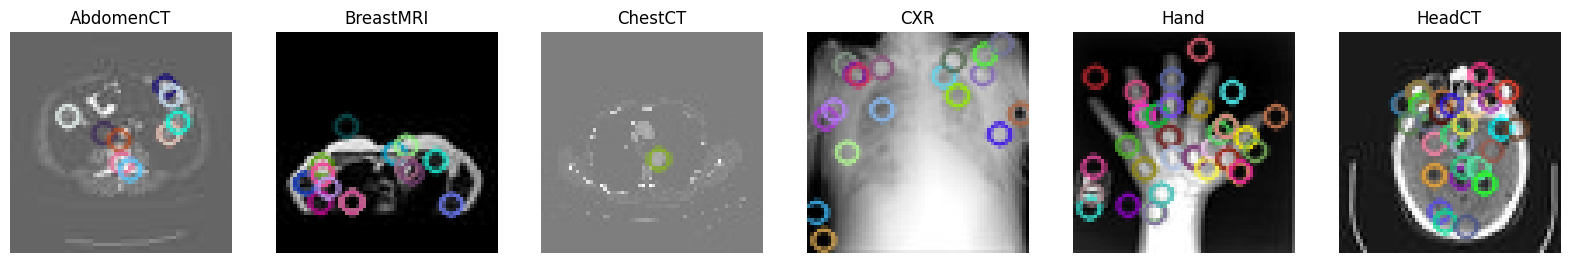

In [111]:
# plot one image for each category
fig, ax = plt.subplots(1, len(LABELS_MNIST), figsize = (20, 20))
for i in range(len(LABELS_MNIST)):
    ind = np.where(y_train_mnist_sbs == i)[0][0]
    
    # get the features'
    image = X_train_mnist_sbs[ind]
    
    # print(image.shape, image.dtype)
    print(max(image.flatten()), min(image.flatten()))
    
    temp_img = (image * 255).astype(np.uint8)
        
    keypoints, _ = extract_sift_features(temp_img)
    
    # plot keypoints
    img = cv2.drawKeypoints(temp_img, keypoints, None)

    # img = img.astype(np.float64)
    
    # print(img.shape, img.dtype)
    print(max(img.flatten()), min(img.flatten()))
    
    ax[i].imshow(img)
    ax[i].set_title(LABELS_MNIST[i])
    ax[i].axis('off')
    
    
    # ax[i].imshow(X_train_covid_sbs[ind].reshape(RESIZE_TO_COVID))
    # ax[i].set_title(LABELS_COVID[i])
    # ax[i].axis('off')

##### GET BOW FOR EACH IMAGE

In [113]:
X_train_covid_bow = np.array([image_to_bag_of_features(image, kmeans_covid) for image in X_train_covid_sbs])
X_test_covid_bow = np.array([image_to_bag_of_features(image, kmeans_covid) for image in X_test_covid_sbs])

X_train_mnist_bow = np.array([image_to_bag_of_features(image, kmeans_mnist) for image in X_train_mnist_sbs])
X_test_mnist_bow = np.array([image_to_bag_of_features(image, kmeans_mnist) for image in X_test_mnist_sbs])

#### TRAIN BOW COVID

In [35]:
param_grid={'C':[0.1,1], 
            # 'gamma':[0.0001,0.01,0.1,1], 
            'kernel':['rbf','poly']} 
  
svc=svm.SVC(probability=True) 

model_grid_svm_covid_bow=GridSearchCV(svc,param_grid,verbose=2)

In [36]:
model_grid_svm_covid_bow.fit(X_train_covid_bow, y_train_covid_sbs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.1s
[CV] END ....................................C=1,

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf', 'poly']}, verbose=2)

In [37]:
# Get the best parameters and scores
print("Best Parameters:", model_grid_svm_covid_bow.best_params_)
print("Best Cross-Validation Score:", model_grid_svm_covid_bow.best_score_)
print("Best Estimator:", model_grid_svm_covid_bow.best_estimator_)

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.31625000000000003
Best Estimator: SVC(C=1, probability=True)


In [38]:
y_pred = model_grid_svm_covid_bow.predict(X_test_covid_bow)
accuracy = accuracy_score(y_test_covid_sbs, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 21.00%


#### TRAIN BOW MNIST

In [114]:
param_grid={'C':[0.1,1],
            # 'gamma':[0.0001,0.01,0.1,1], 
            'kernel':['rbf','poly']}

svc=svm.SVC(probability=True)

model_grid_svm_mnist_bow=GridSearchCV(svc,param_grid,verbose=2)

In [115]:
model_grid_svm_mnist_bow.fit(X_train_mnist_bow, y_train_mnist_sbs)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.1s
[CV] END .................................C=0.1, kernel=poly; total time=   0.1s
[CV] END .................................C=0.1, kernel=poly; total time=   0.1s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END .................................C=0.1, kernel=poly; total time=   0.0s
[CV] END ....................................C=1, kernel=rbf; total time=   0.2s
[CV] END ....................................C=1,

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1], 'kernel': ['rbf', 'poly']}, verbose=2)

In [116]:
# Get the best parameters and scores
print("Best Parameters:", model_grid_svm_mnist_bow.best_params_)
print("Best Cross-Validation Score:", model_grid_svm_mnist_bow.best_score_)
print("Best Estimator:", model_grid_svm_mnist_bow.best_estimator_)

Best Parameters: {'C': 1, 'kernel': 'rbf'}
Best Cross-Validation Score: 0.2298899371069182
Best Estimator: SVC(C=1, probability=True)


In [117]:
y_pred = model_grid_svm_mnist_bow.predict(X_test_mnist_bow)
accuracy = accuracy_score(y_test_mnist_sbs, y_pred) 
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 16.50%


# ENSEMBLE METHODS

### SIFT SIMPLE BOOSTING AND RANDOM FORESTS

In [9]:
TEST_RATIO = 0.2

X_train_covid_emb, X_test_covid_emb, y_train_covid_emb, y_test_covid_emb = train_test_split(covid_images, covid_labels, test_size=TEST_RATIO, random_state=42)
X_train_mnist_emb, X_test_mnist_emb, y_train_mnist_emb, y_test_mnist_emb = train_test_split(mnist_images, mnist_labels, test_size=TEST_RATIO, random_state=42)

In [25]:
MAX_FEATURES = 100

def sift_features_for_all(images):
    sift_features = []

    sum = 0
        
    for image in images:
        _, features = extract_sift_features(image)
            
        if features is not None:
            # print(features.shape)
            
            if features.shape[0] > MAX_FEATURES:
                features = features[:MAX_FEATURES,:]
            else:
                features = np.concatenate((features, np.zeros((MAX_FEATURES - features.shape[0], 128))))
                
            sum += features.shape[0]
            sift_features.append(features)
        else:
            sift_features.append(np.zeros((MAX_FEATURES, 128)))

    
    print("Average Features:", sum / len(images))
    return np.array(sift_features)

In [26]:
X_train_covid_emb_sift = sift_features_for_all(X_train_covid_emb)
X_test_covid_emb_sift = sift_features_for_all(X_test_covid_emb)

X_train_mnist_emb_sift = sift_features_for_all(X_train_mnist_emb)
X_test_mnist_emb_sift = sift_features_for_all(X_test_mnist_emb)

Average Features: 99.875
Average Features: 100.0
Average Features: 97.1105527638191
Average Features: 96.5


In [27]:
print(X_train_covid_emb_sift.shape)

(800, 100, 128)


In [28]:
# Function to flatten descriptors to 1D array
def flatten_descriptors(descriptors_list):
    flattened = []
    for descriptors in descriptors_list:
        flattened.append(descriptors.flatten())  # Flatten each descriptor matrix
    return np.array(flattened)


X_train_covid_emb_sift_flat = flatten_descriptors(X_train_covid_emb_sift)
X_test_covid_emb_sift_flat = flatten_descriptors(X_test_covid_emb_sift)

X_train_mnist_emb_sift_flat = flatten_descriptors(X_train_mnist_emb_sift)
X_test_mnist_emb_sift_flat = flatten_descriptors(X_test_mnist_emb_sift)

##### TRAIN COVID

In [29]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


N_ESTIMATORS = 50

rf_clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=N_ESTIMATORS, random_state=42)

In [30]:
rf_clf.fit(X_train_covid_emb_sift_flat, y_train_covid_emb)

RandomForestClassifier(n_estimators=50, random_state=42)

In [31]:
gb_clf.fit(X_train_covid_emb_sift_flat, y_train_covid_emb)

GradientBoostingClassifier(n_estimators=50, random_state=42)

##### TEST COVID

In [32]:
y_pred = rf_clf.predict(X_test_covid_emb_sift_flat)
accuracy = accuracy_score(y_test_covid_emb, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

Random Forest Accuracy: 48.00%


In [33]:
y_pred = gb_clf.predict(X_test_covid_emb_sift_flat)
accuracy = accuracy_score(y_test_covid_emb, y_pred)
print(f"Gradient Boosting Accuracy: {accuracy * 100:.2f}%")

Gradient Boosting Accuracy: 55.00%


#### TRAIN MNIST

In [34]:
N_ESTIMATORS = 50

rf_clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=N_ESTIMATORS, random_state=42)

In [35]:
rf_clf.fit(X_train_mnist_emb_sift_flat, y_train_mnist_emb)

RandomForestClassifier(n_estimators=50, random_state=42)

In [36]:
gb_clf.fit(X_train_mnist_emb_sift_flat, y_train_mnist_emb)

GradientBoostingClassifier(n_estimators=50, random_state=42)

#### TEST MNIST

In [38]:
y_pred = rf_clf.predict(X_test_mnist_emb_sift_flat)
accuracy = accuracy_score(y_test_mnist_emb, y_pred)
print(f"Random Forest Accuracy: {accuracy * 100:.2f}%")

Random Forest Accuracy: 89.50%


In [39]:
y_pred = gb_clf.predict(X_test_mnist_emb_sift_flat)
accuracy = accuracy_score(y_test_mnist_emb, y_pred)
print(f"Gradient Boosting Accuracy: {accuracy * 100:.2f}%")

Gradient Boosting Accuracy: 90.00%


### SVM BAGGING

In [73]:
from sklearn.ensemble import BaggingClassifier


N_ESTIMATORS = 10


svm = SVC(kernel='poly', C=1, probability=True, random_state=42)


bagging_svm_covid_hog = BaggingClassifier(estimator=svm, n_estimators=N_ESTIMATORS, random_state=42)

bagging_svm_mnist_hog = BaggingClassifier(estimator=svm, n_estimators=N_ESTIMATORS, random_state=42)

bagging_svm_covid_sift = BaggingClassifier(estimator=svm, n_estimators=N_ESTIMATORS, random_state=42)

bagging_svm_mnist_sift = BaggingClassifier(estimator=svm, n_estimators=N_ESTIMATORS, random_state=42)

##### TRAIN COVID HOG

In [70]:
bagging_svm_covid_hog.fit(X_train_covid_hog, y_train_covid_hog)

BaggingClassifier(estimator=SVC(C=1, kernel='poly', probability=True,
                                random_state=42),
                  random_state=42)

##### TEST COVID HOG

In [71]:
y_pred = bagging_svm_covid_hog.predict(X_test_covid_hog)
accuracy = accuracy_score(y_test_covid_hog, y_pred)
print(f"Bagging SVM Accuracy: {accuracy * 100:.2f}%")

Bagging SVM Accuracy: 77.50%


##### TRAIN MNIST HOG

In [76]:
bagging_svm_mnist_hog.fit(X_train_mnist_hog, y_train_mnist_hog)

BaggingClassifier(estimator=SVC(C=1, kernel='poly', probability=True,
                                random_state=42),
                  random_state=42)

##### TEST MNIST HOG

In [77]:
y_pred = bagging_svm_mnist_hog.predict(X_test_mnist_hog)
accuracy = accuracy_score(y_test_mnist_hog, y_pred)
print(f"Bagging SVM Accuracy: {accuracy * 100:.2f}%")

Bagging SVM Accuracy: 99.50%


##### TRAIN COVID SIFT

In [81]:
bagging_svm_covid_sift.fit(X_train_covid_emb_sift_flat, y_train_covid_emb)

BaggingClassifier(estimator=SVC(C=1, kernel='poly', probability=True,
                                random_state=42),
                  random_state=42)

##### TEST COVID SIFT

In [82]:
y_pred = bagging_svm_covid_sift.predict(X_test_covid_emb_sift_flat)
accuracy = accuracy_score(y_test_covid_emb, y_pred)
print(f"Bagging SVM Accuracy: {accuracy * 100:.2f}%")

Bagging SVM Accuracy: 51.00%


##### TRAIN MNIST SIFT

In [84]:
bagging_svm_mnist_sift.fit(X_train_mnist_emb_sift_flat, y_train_mnist_emb)

BaggingClassifier(estimator=SVC(C=1, kernel='poly', probability=True,
                                random_state=42),
                  random_state=42)

##### TEST MNIST SIFT

In [85]:
y_pred = bagging_svm_mnist_sift.predict(X_test_mnist_emb_sift_flat)
accuracy = accuracy_score(y_test_mnist_emb, y_pred)
print(f"Bagging SVM Accuracy: {accuracy * 100:.2f}%")

Bagging SVM Accuracy: 86.50%
